In [69]:
import itertools
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

plotnine.options.figure_size = (12, 12)
import warnings
warnings.filterwarnings("ignore")

In [2]:
transformer = "distilbert-base-cased"
#transformer = "roberta-base"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)
model = AutoModelForMaskedLM.from_pretrained(transformer)
model.eval()
model.zero_grad()

In [3]:
def prepare_data_for_sentence(sent, N):
    input_seq = tokenizer.encode(sent)

    mask_index = input_seq.index(tokenizer.mask_token_id)
#    print(mask_index)

    input_tensor = torch.tensor([input_seq])

    input_result = model.forward(input_tensor, return_dict=True)

    input_result.logits.shape

    token_logits = input_result.logits
    mask_token_logits = token_logits[0, mask_index, :]
    mask_token_probs = torch.nn.functional.softmax(mask_token_logits, dim=0)

    # get the top predictions for the non-occluded sentence
    top_N = torch.topk(mask_token_probs, N, dim=0)
#    print(top_N)
    probs = top_N.values.tolist()
    top_N_tokens = top_N.indices.tolist()
#    print(probs, sum(probs), top_N_tokens)
    return input_seq, top_N_tokens, mask_index

In [38]:
def custom_forward(inputs, attention_mask=None, pos=0):
#    result = model.forward(inputs.double(), return_dict=True, attention_mask=attention_mask)
#    print("POS", pos)
    result = model.forward(inputs, return_dict=True, attention_mask=attention_mask)
    preds = result.logits
#    print("PREDS SHAPE:", preds.shape)
    N_token = preds[:, pos, :]
#()    print("SHAPE", N_token.shape)
    return N_token

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def construct_whole_bert_embeddings(input_ids, ref_input_ids):
    
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    #, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    #, token_type_ids=token_type_ids, position_ids=position_ids)

    return input_embeddings, ref_input_embeddings


def run_attribution_model(input_seq, ref_token_id, top_N_tokens, mask_index):
    interpretable_embedding = configure_interpretable_embedding_layer(model, 'distilbert.embeddings')
    try:
        ablator = IntegratedGradients(custom_forward)

        input_tensor = torch.tensor([input_seq] * len(top_N_tokens))
        ref_tensor = torch.tensor([ref_token_id]).expand((1,len(input_seq)))
        interpretable_input_tensor = interpretable_embedding.indices_to_embeddings(input_tensor)
        ref_tensor = interpretable_embedding.indices_to_embeddings(ref_tensor)

        attention_mask = torch.ones_like(input_tensor)
        attributions = ablator.attribute(
                inputs=interpretable_input_tensor,
                baselines=ref_tensor,
                additional_forward_args=(attention_mask,mask_index),
                target=top_N_tokens,
        )
        attributions = summarize_attributions(attributions)
    finally:
        remove_interpretable_embedding_layer(model, interpretable_embedding)

    return attributions.T

In [39]:
def build_dataframe(attributions, input_seq, top_N_tokens):

    ix = pd.CategoricalIndex(
                [tokenizer.decode([token]) for token in input_seq],
                categories=reversed([tokenizer.decode([token]) for token in input_seq]),
                ordered=True
            )
#    print(ix)
    attr_df = (
        pd.DataFrame(
                attributions.detach().numpy(), 
                columns=[tokenizer.decode([token]) for token in top_N_tokens],
                index=ix,
            )
        .reset_index()
    )
    attr_df = attr_df.melt(id_vars=["index"])
    #attr_df = attr_df[~(attr_df['index'] == tokenizer.mask_token)]
    attr_df['variable'] = pd.Categorical(
            attr_df['variable'], 
            categories = [tokenizer.decode([token]) for token in top_N_tokens], 
            ordered=True
        )
    attr_df['display_value'] = attr_df['value'].apply(lambda f: f"{f:.2f}")
    return attr_df
    

In [101]:
def create_plot(attr_df, mask_index, N):
    ncol = np.ceil(np.sqrt(N))
    return (ggplot(attr_df, aes(x="index", y="value")) + 
        geom_col(aes(fill="index", colour="index"))  +
        geom_text(aes(y="value/2", label="display_value"), size=10) +
#        geom_label(aes(x = len(input_seq) - mask_index, y= 0, label="variable"), size=13, boxstyle="darrow") +
        scale_x_discrete(drop=False) +
        facet_wrap("~variable", ncol=ncol) +
        coord_flip() +
        labs(
                x="target token",
                y="Captum contribution scores",
#                title="Exploring the contribution of each token to the prediction."
            ) +
        theme(legend_position="none")
    )

In [84]:
def run_and_show(sentence, mask_tokens, reference=[tokenizer.unk_token_id]):
    if isinstance(mask_tokens, int):
        N = mask_tokens
        input_seq, mask_tokens, mask_index = prepare_data_for_sentence(sentence, N)
    else:
        N = len(mask_tokens)
        if isinstance(mask_tokens[0], str):
            mask_tokens = tokenizer.convert_tokens_to_ids(mask_tokens)
        input_seq, _, mask_index = prepare_data_for_sentence(sentence, N)

    attributions = []
    for ref in reference:
        attributions.append(run_attribution_model(input_seq, ref, mask_tokens, mask_index))
    attributions = torch.stack(attributions).mean(axis=0)
    df = build_dataframe(attributions, input_seq, mask_tokens)
    plot = create_plot(df, mask_index, N)
    display(plot)
    return df, mask_index

/home/martijn/miniconda3/envs/hug2/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 


torch.Size([2, 7])
torch.Size([1, 7])
torch.Size([2, 7, 768])
torch.Size([1, 7, 768])
POS 4
PREDS SHAPE: torch.Size([100, 7, 28996])
SHAPE torch.Size([100, 28996])
torch.Size([2, 7, 768])
torch.Size([2, 7])
torch.Size([2, 7])
torch.Size([1, 7])
torch.Size([2, 7, 768])
torch.Size([1, 7, 768])
POS 4
PREDS SHAPE: torch.Size([100, 7, 28996])
SHAPE torch.Size([100, 28996])
torch.Size([2, 7, 768])
torch.Size([2, 7])
[tensor([[0.1017, 0.2479],
        [0.0709, 0.0286],
        [0.4675, 0.5418],
        [0.2706, 0.2242],
        [0.0362, 0.1854],
        [0.1520, 0.1331],
        [0.3013, 0.3456]], dtype=torch.float64, grad_fn=<PermuteBackward0>), tensor([[ 0.0058, -0.0532],
        [ 0.0418,  0.0347],
        [ 0.3590,  0.3437],
        [ 0.4602,  0.4457],
        [ 0.0305,  0.0433],
        [ 0.2449,  0.0503],
        [ 0.0833, -0.5143]], dtype=torch.float64, grad_fn=<PermuteBackward0>)]
tensor([[ 0.0538,  0.0973],
        [ 0.0563,  0.0317],
        [ 0.4133,  0.4427],
        [ 0.3654,  0.

/home/martijn/miniconda3/envs/hug2/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/martijn/miniconda3/envs/hug2/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


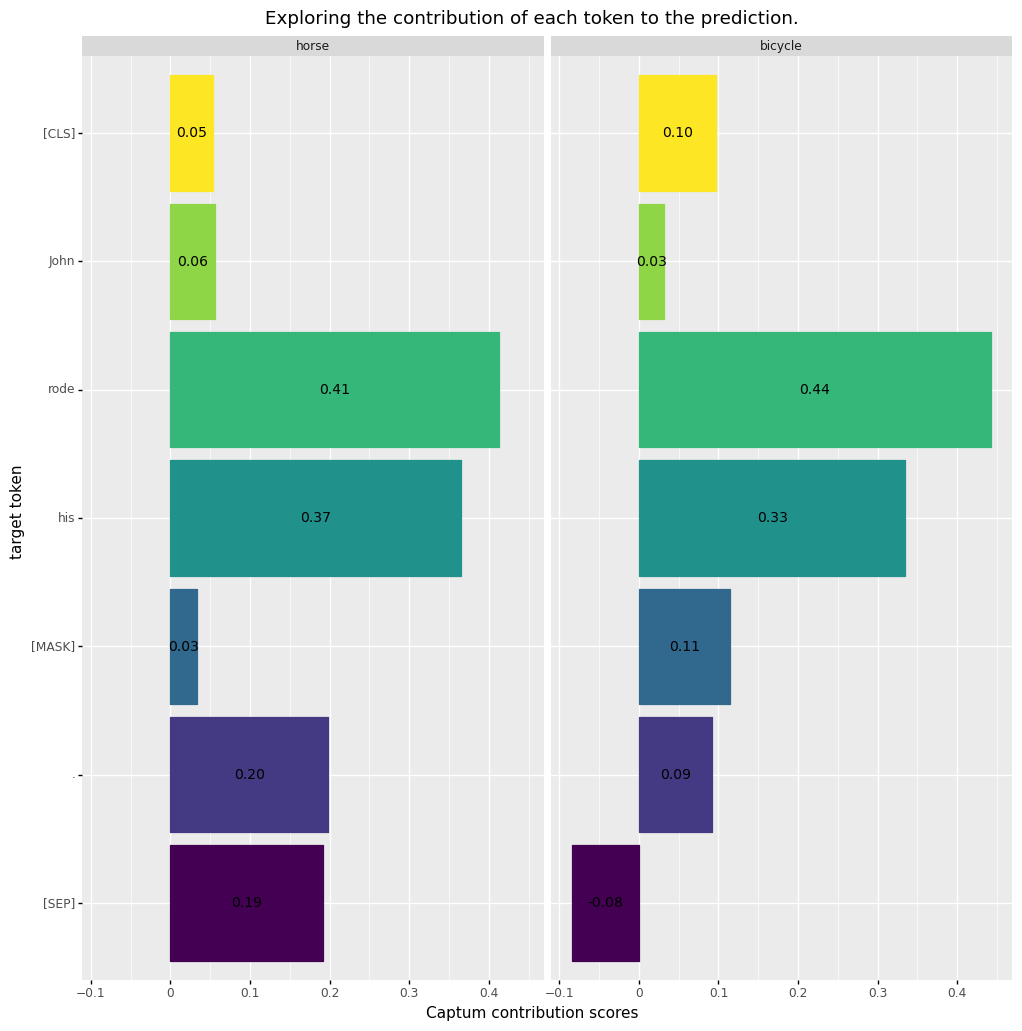

<ggplot: (8785672042707)>

In [35]:
_ = run_and_show(f"John rode his {tokenizer.mask_token}.", ["horse", "bicycle"], reference=[tokenizer.unk_token_id, tokenizer.pad_token_id])

/home/martijn/miniconda3/envs/hug2/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 


torch.Size([2, 7])
torch.Size([1, 7])
torch.Size([2, 7, 768])
torch.Size([1, 7, 768])
POS 4
PREDS SHAPE: torch.Size([100, 7, 28996])
SHAPE torch.Size([100, 28996])
torch.Size([2, 7, 768])
torch.Size([2, 7])
[tensor([[0.1017, 0.2479],
        [0.0709, 0.0286],
        [0.4675, 0.5418],
        [0.2706, 0.2242],
        [0.0362, 0.1854],
        [0.1520, 0.1331],
        [0.3013, 0.3456]], dtype=torch.float64, grad_fn=<PermuteBackward0>)]
tensor([[0.1017, 0.2479],
        [0.0709, 0.0286],
        [0.4675, 0.5418],
        [0.2706, 0.2242],
        [0.0362, 0.1854],
        [0.1520, 0.1331],
        [0.3013, 0.3456]], dtype=torch.float64, grad_fn=<MeanBackward1>)
att torch.Size([7, 2])


/home/martijn/miniconda3/envs/hug2/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/martijn/miniconda3/envs/hug2/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


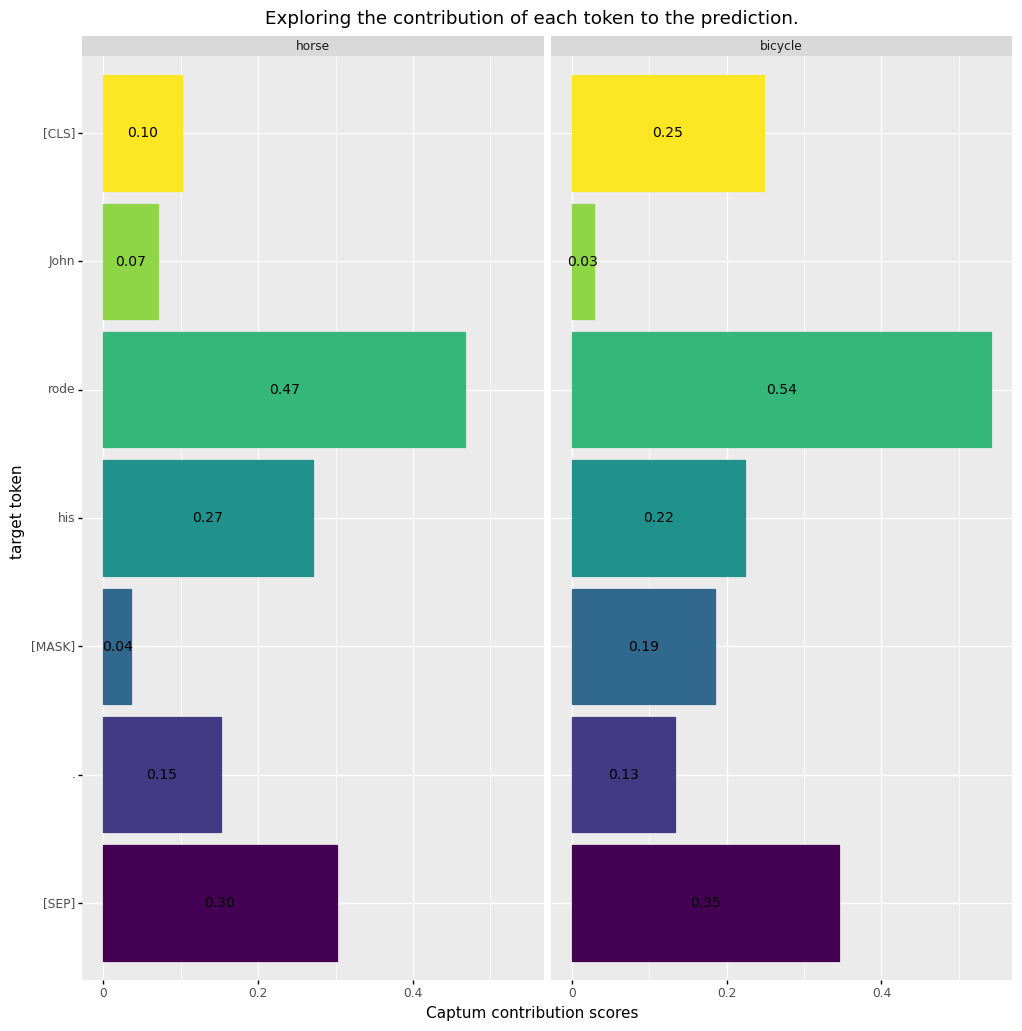

<ggplot: (8785675154559)>

In [34]:
_ = run_and_show(f"John rode his {tokenizer.mask_token}.", ["horse", "bicycle"])

In [94]:
from numpy.random import default_rng
rng = default_rng()
sample = rng.integers(model.config.vocab_size, size=20)
print(sample)

[ 2610  5076  1120 15877 14825 24402 23204  3576 23309 14194  5898   119
 12355 21461 25325 25340 24074  4302 22644 16279]


In [96]:
[tokenizer.decode([token]) for token in sample]

['larger',
 'studying',
 'at',
 'Pitt',
 'contractor',
 'parting',
 'colonization',
 'etc',
 'oppression',
 '##vant',
 'orchestra',
 '.',
 '##oto',
 'mildly',
 '229',
 '##film',
 'apprenticeship',
 'Nothing',
 'Milo',
 '##cting']

unknown token


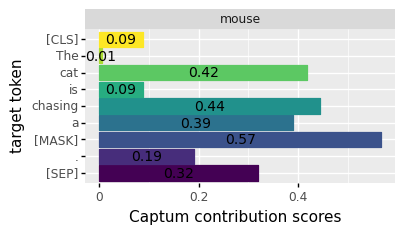

<ggplot: (8785674638839)>

pad token


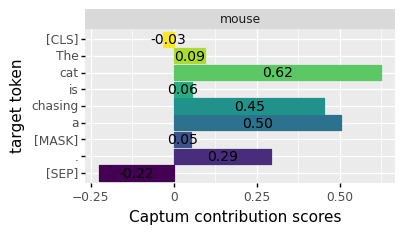

<ggplot: (8785654469970)>

unknown and pad tokens


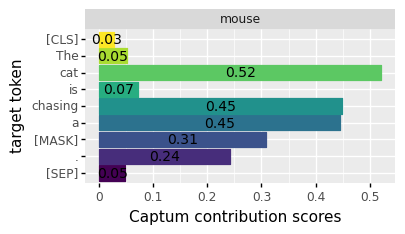

<ggplot: (8785654468362)>

20 random token sample


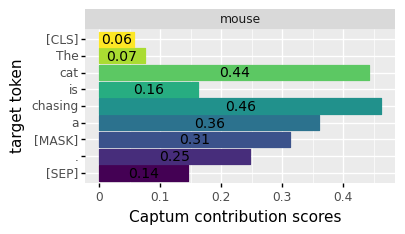

<ggplot: (8785676207472)>

CPU times: user 1min 2s, sys: 148 ms, total: 1min 2s
Wall time: 16.3 s


In [102]:
%%time
plotnine.options.figure_size = (4, 2)
print("unknown token")
_ = run_and_show(f"The cat is chasing a {tokenizer.mask_token}.", ["mouse"], reference=[tokenizer.unk_token_id])
print("pad token")
_ = run_and_show(f"The cat is chasing a {tokenizer.mask_token}.", ["mouse"], reference=[tokenizer.pad_token_id])
print("unknown and pad tokens")
_ = run_and_show(f"The cat is chasing a {tokenizer.mask_token}.", ["mouse"], reference=[tokenizer.unk_token_id, tokenizer.pad_token_id])
print("20 random token sample")
_ = run_and_show(f"The cat is chasing a {tokenizer.mask_token}.", ["mouse"], reference=sample)